# Exploratory Data Analysis<a id='Exploratory_Data_Analysis'></a>

### 1 Table of Contents<a id='Contents'></a>
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
  * [1 Contents](#Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Load Data](#4_Load_Data)
  * [5 Traffic Counts](#5_Traffic_Counts)
      * [5.1 Geocoding](#5.1_Geocoding)
      * [5.2 Mapping](#5.2_Mapping)
      * [5.3 Counts](#5.3_Counts)
  * [6 Explore](#6_Explore)
  * [7 Target Feature](#7_Target_Feature)
  * [8 Save Data](#8_Save_Data)
  * [9 Conclusion](#9_Conclusion)

### 2 Introduction<a id='2_Introduction'>

In the last notebook, the data was cleaned and the weather and collision data was merged into a single dataframe. The Google Maps API and OpenWeather API were also investigated. The Google Maps API returns a number of routes with a varying number of steps in each route. The start and end coordinates are given for each step of each route. The OpenWeather API provides data that looks almost identical to the weather dataset from the last notebook. 

In this notebook, the different features will be investigated and compared. The goal for the end of this notebook is to have a good idea of the features that will feed into the model and what form those features should take.

### 3 Imports<a id='3_Imports'>

In [1]:
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pandas_profiling
import requests
import gmaps
import googlemaps
from library.sb_utils import save_file
import os
import math
import csv

### 4 Load Data<a id='4_Load_Data'>

The data is stored in the LA_Data file, which is the merged set of weather and collisions

In [2]:
LA_data = pd.read_csv('../Data/LA_data.csv', index_col = 'Unnamed: 0')
LA_traffic_counts = pd.read_csv('../Data/LA_traffic_counts.csv', index_col = 'Unnamed: 0')
openWeather_api_key = pd.read_json('../credentials.json', typ='series')['openWeather_api_key']
maps_api_key = pd.read_json('../credentials.json', typ='series')['maps_api_key']

In [3]:
LA_data.head()

,level_0,index,primary_road,secondary_road,intersection,side_of_highway,severity,type,pedestrian,bicycle,...,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,clouds_all
0,0,0,CENTINELA AV,BEACH AV,0.0,Not Available,pain,broadside,0,0,...,20.21,32.14,1014,54,1.34,293,0.45,0.0,0.0,0
1,1,1,CRENSHAW BL,VERNON AV,0.0,Not Available,Not Available,Not Available,0,0,...,20.21,32.14,1014,54,1.34,293,0.45,0.0,0.0,0
2,2,2,MANCHESTER BLVD,11TH AV,1.0,Not Available,pain,broadside,0,0,...,19.10,31.11,1013,58,2.57,0,0.00,0.0,0.0,0
3,3,3,I-710 NORTHBOUND(LONG BEACH FREEWAY),IMPERIAL HWY,0.0,Not Available,property damage only,rear end,0,0,...,19.10,31.11,1013,58,2.57,0,0.00,0.0,0.0,0
4,4,4,JEFFERSON,2ND AV,0.0,Not Available,Not Available,Not Available,0,0,...,19.10,31.11,1013,58,2.57,0,0.00,0.0,0.0,0


In [4]:
LA_data.columns

Index(['level_0', 'index', 'primary_road', 'secondary_road', 'intersection',
       'side_of_highway', 'severity', 'type', 'pedestrian', 'bicycle',
       'motorcycle', 'truck', 'same_day_crashes', 'same_road_crashes',
       'latitude', 'longitude', 'datetime', 'temp', 'visibility', 'dew_point',
       'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h', 'clouds_all'],
      dtype='object')

In [5]:
LA_data.shape

(825506, 30)

In [6]:
LA_data['longitude']

0        -118.34786
1        -118.33060
2        -118.32868
3        -118.17820
4        -118.31890
            ...    
825501   -118.33860
825502   -118.32880
825503   -118.30330
825504   -118.36660
825505   -118.30900
Name: longitude, Length: 825506, dtype: float64

### 5 Traffic Counts<a id='5_Traffic_Counts'>

#### 5.1 Geocoding<a id='5.1_Geocoding'>

The traffic count data that is available is only for a small number of streets, compared to the total number of streets. This data can be used, however, to infer information about the other streets

In [7]:
LA_traffic_counts.head()

,primary_road,secondary_road,Count Date,Total
0,1 st ST,MC CADDEN PL,February 05 2013,1127.0
1,1 st ST,ALAMEDA ST,January 16 2014,18102.0
2,1 st ST,MAIN ST,March 27 2013,19032.0
3,1 st ST,SPRING ST,March 19 2013,19249.0
4,1 st ST,MAIN ST,November 08 2011,23897.0


In [8]:
LA_traffic_counts.shape

(5938, 4)

To start, latitude and longitude values are obtained for each location using the Google Maps Geocoding API using the primary and secondary road.

In [9]:
API_KEY = maps_api_key
response = requests.get(
    f'https://maps.googleapis.com/maps/api/geocode/json?address=1+st+ST+and+MC+CADDEN+PL,+Los+Angeles,+CA&key={API_KEY}')

In [10]:
lat = response.json()['results'][0]['geometry']['location']['lat']
lon = response.json()['results'][0]['geometry']['location']['lng']

In [11]:
print(lat)
print(lon)

34.0736031
-118.3372133


Now, to do that for the entire dataframe. To not overuse the API, the duplicate intersections don't need to be requested. A seperate dataframe will be made for this purpose.

In [12]:
unique_intersections = LA_traffic_counts[['primary_road', 'secondary_road']].drop_duplicates(ignore_index = True)
unique_intersections.head()

,primary_road,secondary_road
0,1 st ST,MC CADDEN PL
1,1 st ST,ALAMEDA ST
2,1 st ST,MAIN ST
3,1 st ST,SPRING ST
4,10 th AV,48 th ST


In [13]:
API_KEY = maps_api_key
def getCoords(p_road, s_road):
    p_road = p_road.replace(' ', '+')
    s_road = s_road.replace(' ', '+')
    try:
        response = requests.get(
            f'https://maps.googleapis.com/maps/api/geocode/json?address={p_road}+and+{s_road},+Los+Angeles,+CA&key={API_KEY}')
        coords = (response.json()['results'][0]['geometry']['location']['lat']
                     , response.json()['results'][0]['geometry']['location']['lng'])
    except:
        return 'N/A'
    else:
        return coords

In [14]:
getCoords(unique_intersections['primary_road'][0], unique_intersections['secondary_road'][0])

(34.0736031, -118.3372133)

Now the coordinates can be obtained

In [15]:
coords = [0] * unique_intersections.shape[0]
for idx in range(unique_intersections.shape[0]):
    coords[idx] = getCoords(unique_intersections['primary_road'][idx], unique_intersections['secondary_road'][idx])

In [16]:
unique_intersections['lat'], unique_intersections['lon'] = zip(*coords)

In [17]:
unique_intersections.head()

,primary_road,secondary_road,lat,lon
0,1 st ST,MC CADDEN PL,34.073603,-118.337213
1,1 st ST,ALAMEDA ST,34.048943,-118.238117
2,1 st ST,MAIN ST,34.052239,-118.243398
3,1 st ST,SPRING ST,34.05294,-118.244467
4,10 th AV,48 th ST,34.000268,-118.258673


In [18]:
unique_intersections = unique_intersections[unique_intersections['lat'] != 'N']

#### 5.2 Mapping<a id='5.2_Mapping'>

In [19]:
gmaps.configure(api_key = maps_api_key)
LA_coords = (34.0522, -118.2437)
fig = gmaps.figure(center = LA_coords, zoom_level = 10)
fig.add_layer(gmaps.symbol_layer(unique_intersections[['lat','lon']]))
fig

Figure(layout=FigureLayout(height='420px'))

From the map above, The intersections that have traffic count data are pretty well spread out. This is great, as it allows for making assumptions about the rest of the intersections depending on the surrounding ones. As well, the traffic volume data covers generally the same area as the collision data.

#### 5.3 Counts<a id='5.3_Counts'>

First, to get averages of traffic counts for each intersection dataframe. These averages can then be joined to the unique_intersections dataframe

In [20]:
intersection_avg = LA_traffic_counts.groupby(by = ['primary_road', 'secondary_road'])['Total'].mean()
intersection_avg.head()

primary_road                secondary_road
1 st ST                     ALAMEDA ST        18102.0
                            MAIN ST           21464.5
                            MC CADDEN PL       1127.0
                            SPRING ST         19249.0
10 FWY E/B ON AND OFF RAMP  PORTER ST          5645.0
Name: Total, dtype: float64

In [21]:
LA_traffic = unique_intersections.merge(intersection_avg, on = ['primary_road', 'secondary_road'])
LA_traffic.head()

,primary_road,secondary_road,lat,lon,Total
0,1 st ST,MC CADDEN PL,34.073603,-118.337213,1127.0
1,1 st ST,ALAMEDA ST,34.048943,-118.238117,18102.0
2,1 st ST,MAIN ST,34.052239,-118.243398,21464.5
3,1 st ST,SPRING ST,34.05294,-118.244467,19249.0
4,10 th AV,48 th ST,34.000268,-118.258673,643.0


The above is a dataframe of all unique intersections and the corresponding average traffic counts. How about another map, but this time with a heatmap layer showing the average counts

In [22]:
gmaps.configure(api_key = maps_api_key)
LA_coords = (34.0522, -118.2437)
fig = gmaps.figure(center = LA_coords, zoom_level = 10)
fig.add_layer(gmaps.heatmap_layer(LA_traffic[['lat','lon']], weights = LA_traffic['Total'], max_intensity = 250000))
fig

Figure(layout=FigureLayout(height='420px'))

As expected, traffic is heavier in the center of the city.

### 6 Explore<a id='6_Explore'>

#### 6.1 Spatial Resolution<a id='6.1_Spatial_Resolution'>

The plan to model accidents across the city of Los Angeles requires both spatial and temporal slicing. To figure out the best spatial and temporal resolution, different slices are taken at varying resolutions and the resulting density of accidents is explored.

In [23]:
print(LA_traffic['lat'].min())
print(LA_traffic['lat'].max())
print(LA_traffic['lon'].min())
print(LA_traffic['lon'].max())

33.5969319
41.2033216
-119.0987176
-77.1945247


That maximum longitude and latitude values are way off. What's the intersection?

In [24]:
LA_traffic[LA_traffic['lon'] == -77.1945247]

,primary_road,secondary_road,lat,lon,Total
3853,PENNSYLVANIA AV / IOWA AV,CENTINELA AV,41.203322,-77.194525,1305.0


The api must've gotten confused due to the double primary road. A google search reveals the true coordinates to be (34.034601, -118.463089)

In [25]:
LA_traffic.loc[LA_traffic.primary_road == 'PENNSYLVANIA AV / IOWA AV', 'lat'] = 34.034601
LA_traffic.loc[LA_traffic.primary_road == 'PENNSYLVANIA AV / IOWA AV', 'lon'] = -118.463089

In [26]:
print(LA_traffic['lat'].max())
print(LA_traffic['lon'].max())

36.4135605
-117.8825555


These numbers make much more sense.

In [27]:
print(LA_data['latitude'].min())
print(LA_data['latitude'].max())
print(LA_data['longitude'].min())
print(LA_data['longitude'].max())

33.3427
34.692
-118.6673
-117.7059


(0, 0) is obviously wrong. How many rows have a latitude and longitude of 0

In [28]:
LA_data[LA_data.latitude == 0].shape

(0, 30)

Not too many. Those rows will be dropped, as there is plenty of collision data already and using the geocoding api more will cost money.

In [29]:
LA_data = LA_data[LA_data.latitude > 0]

In [32]:
print(LA_data['latitude'].min())
print(LA_data['latitude'].max())
print(LA_data['longitude'].min())
print(LA_data['longitude'].max())

33.3427
34.692
-118.6673
-117.7059


Now it's clear that the range is similar between the two datasets.

Now, a dataframe can be made representing a grid of latitudes and longitudes, which can be filled with the count of accidents within each grid cell. The minimums and maximums from the collision dataset will be used as the bounds of our axes, as this range is bigger one. The area covered by this data is roughly 48 miles by 81 miles, so there should be about 1.7 times more rows than columns, in order to keep the grid cells approximately square. First, 100 steps will be used for the number of columns (longitudes). 

In [33]:
lats, lats_step = np.linspace(LA_data['latitude'].max(), LA_data['latitude'].min(), num = math.floor(100 * (81/48)), retstep = True)
lons, lons_step = np.linspace(LA_data['longitude'].min(), LA_data['longitude'].max(), num = 100, retstep = True)

In [34]:
lat_lon_grid = pd.DataFrame(data = np.zeros((math.floor(100 * (81/48)),100)), index = lats, columns = lons)

In [35]:
lat_idxs = (LA_data['latitude'] - LA_data['latitude'].max()) / lats_step
lon_idxs = (LA_data['longitude'] - LA_data['longitude'].min()) / lons_step

In [36]:
for idx0 in range(lat_idxs.shape[0]):
    lat_idx = math.floor(lat_idxs.iloc[idx0])
    lon_idx = math.floor(lon_idxs.iloc[idx0])
    lat_lon_grid.iloc[lat_idx, lon_idx] += 1

In [37]:
(lat_lon_grid == 0).sum().sum()

14361

In [38]:
(14361 / 16800) * 100

85.48214285714286

With a 168x100 grid, there are about 85 percent of cells that have never seen an accident. To find the best value, the previous method will be repeated multiple times and the percent of empty cells investigated for each resolution.

In [39]:
def testResolution(numSamples):
    lats, lats_step = np.linspace(
        LA_data['latitude'].max(), LA_data['latitude'].min(), num = math.floor(numSamples * (81/48)), retstep = True)
    lons, lons_step = np.linspace(
        LA_data['longitude'].min(), LA_data['longitude'].max(), num = numSamples, retstep = True)
    lat_lon_grid = pd.DataFrame(data = np.zeros((math.floor(numSamples * (81/48)),numSamples)), index = lats, columns = lons)
    lat_idxs = (LA_data['latitude'] - LA_data['latitude'].max()) / lats_step
    lon_idxs = (LA_data['longitude'] - LA_data['longitude'].min()) / lons_step
    for idx0 in range(lat_idxs.shape[0]):
        lat_idx = math.floor(lat_idxs.iloc[idx0])
        lon_idx = math.floor(lon_idxs.iloc[idx0])
        lat_lon_grid.iloc[lat_idx, lon_idx] += 1
    percent_missing = ((lat_lon_grid == 0).sum().sum() / (lat_lon_grid.shape[0] * lat_lon_grid.shape[1])) * 100
    return percent_missing

In [40]:
resolutions = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
percents_missing = []
for i in resolutions:
    percents_missing.append(testResolution(int(i)))

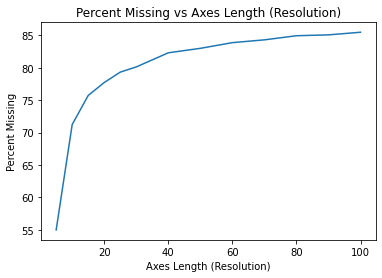

In [41]:
plt.plot(resolutions, percents_missing)
plt.title('Percent Missing vs Axes Length (Resolution)')
plt.ylabel('Percent Missing')
plt.xlabel('Axes Length (Resolution)')
plt.show()

As expected, the number of empty cells increases as the resolution increases. The graph start to level off at 30 columns, which is also means 50 columns  . However, the percent missing does increase by about another seven or eight percent above that resolutions, so 50x30 is a good trade off in resolution and data sparsity.

What about the traffic volume data?

In [42]:
def testVolResolution(numSamples):
    lats, lats_step = np.linspace(
        LA_traffic['lat'].max(), LA_traffic['lat'].min(), num = math.floor(numSamples * (81/48)), retstep = True)
    lons, lons_step = np.linspace(
        LA_traffic['lon'].min(), LA_traffic['lon'].max(), num = numSamples, retstep = True)
    lat_lon_grid = pd.DataFrame(data = np.zeros((math.floor(numSamples * (81/48)),numSamples)), index = lats, columns = lons)
    lat_idxs = (LA_traffic['lat'] - LA_traffic['lat'].max()) / lats_step
    lon_idxs = (LA_traffic['lon'] - LA_traffic['lon'].min()) / lons_step
    for idx0 in range(lat_idxs.shape[0]):
        lat_idx = math.floor(lat_idxs.iloc[idx0])
        lon_idx = math.floor(lon_idxs.iloc[idx0])
        lat_lon_grid.iloc[lat_idx, lon_idx] += 1
    percent_missing = ((lat_lon_grid == 0).sum().sum() / (lat_lon_grid.shape[0] * lat_lon_grid.shape[1])) * 100
    return percent_missing

In [43]:
resolutions = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70]
percents_missing = []
for i in resolutions:
    percents_missing.append(testVolResolution(int(i)))

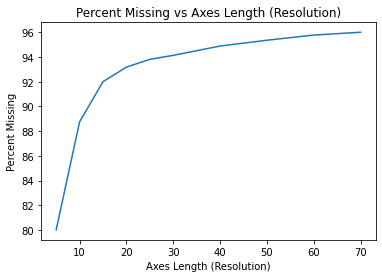

In [44]:
plt.plot(resolutions, percents_missing)
plt.title('Percent Missing vs Axes Length (Resolution)')
plt.ylabel('Percent Missing')
plt.xlabel('Axes Length (Resolution)')
plt.show()

50x30 still seems like the best option for both resolution and sparsity, so that will be the final choice.

#### 6.2 Temporal Resolution<a id='6.2_Temporal_Resolution'>

The traffic count dataframe does not have a time component, but the collision data does. What's the timeframe of the data?

In [45]:
print(LA_data['datetime'].min())
print(LA_data['datetime'].max())

2010-01-01 00:00:00
2021-12-31 15:00:00


In [46]:
LA_data['datetime'] = pd.to_datetime(LA_data['datetime'])

In [47]:
diffs = []
times = LA_data['datetime'].sort_values()
for idx in range(1, LA_data.shape[0]):
    diffs.append(times[idx] - times[idx - 1])

In [48]:
diffs

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 02:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('-3 days +15:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 16:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('-1 days +10:00:00'),
 Timedelta('-2 days +22:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 16:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('-1 days +16:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('-1 days +21:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 04:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('-2 days +11:00:00'),
 Timedelta('0 days 00:00:00

There are many instances where accidents happen at the same time and some instances were there were multiple days with no accidents

The temporal resolution does not need to be tested for in the same way as the spatial resolution. In fact, it can be determined just by considering the utility of the final model. A daily predictions is a little too long to be super useful to a user; the accident is not occuring (or affecting traffic or risking safety) all day long. Minutely predictions, however, is very frequent, and will require a lot of computation. An hour seems like the right choice; the weather api can return hourly weather predictions and the collision data is already in the format of hourly periods, so that will be the final choice.

### 7 Target Feature<a id='7_Target_Feature'>

The target feature is the 1 or 0 in the grid cell, representing whether an accident is predicted to occur in that zone. The 30x30 grid, aptly named target_grid, is just that. Although, currently the grid represents the total number of collisions in that zone over the entire period of our data, not separated by hour, as the final grid will be. The explanatory features are the weather and traffic volume data. The volume data is static, i.e. has no temporal component, and will have the same values in all tensors but will be specific to each grid cell. The weather does have a temporal component, and like the volume data will be specific to each grid cell

### 8 Save Data<a id='8_Save_Data'>

In [49]:
datapath = '../data'
save_file(LA_data, 'LA_data.csv', datapath)
save_file(LA_traffic, 'LA_traffic.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data/LA_data.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data/LA_traffic.csv"


### 9 Conclusion<a id='9_Conclusion'>

In this notebook, the coordinates for the traffic volume were found. The accident density was plotted as heatmap on a map of Los Angeles, as well as the traffic volume. The best resolution for the spatial and temporal components were determined based on the trade off with geographical sparsity of available data. A 50x30 grid will be used for the spatial component, with a period of 1 hour for the temporal component. The area covered by the grid is roughly 81mi x 48 mi., so the spatial resolution is about 1.6 mi.

The input to the model will be built of tensors representing the weather and traffic flows for each zone over time. The output of the model will be a 1 or a 0, representing whether an accident is expected to occur within that grid cell in the next hour. 